# Setup

In [33]:
LOG_PLOT = False
NDAYS=100

In [34]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
from datetime import datetime
from ecdc import ECDC

## ECDC Data

In [35]:
ecdc = ECDC()
df = ecdc.df
print(ecdc.df.dateRep.max())
df.columns


2020-10-21 00:00:00


Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')

## DF Subsets

In [36]:
EU = df[df.continentExp=='Europe'].groupby('dateRep', as_index=False).agg({'cases': sum})
AMERICA = df[(df.continentExp=='America')]


<IPython.core.display.Javascript object>


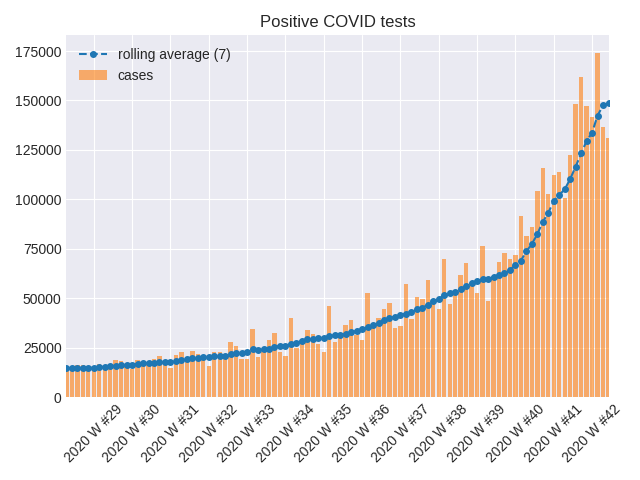

<AxesSubplot:title={'center':'Positive COVID tests'}>

In [37]:
ecdc.plot_selection(EU, ndays=NDAYS, roll_days=7)

# Overview

## Austria, USA, India, ...

<IPython.core.display.Javascript object>


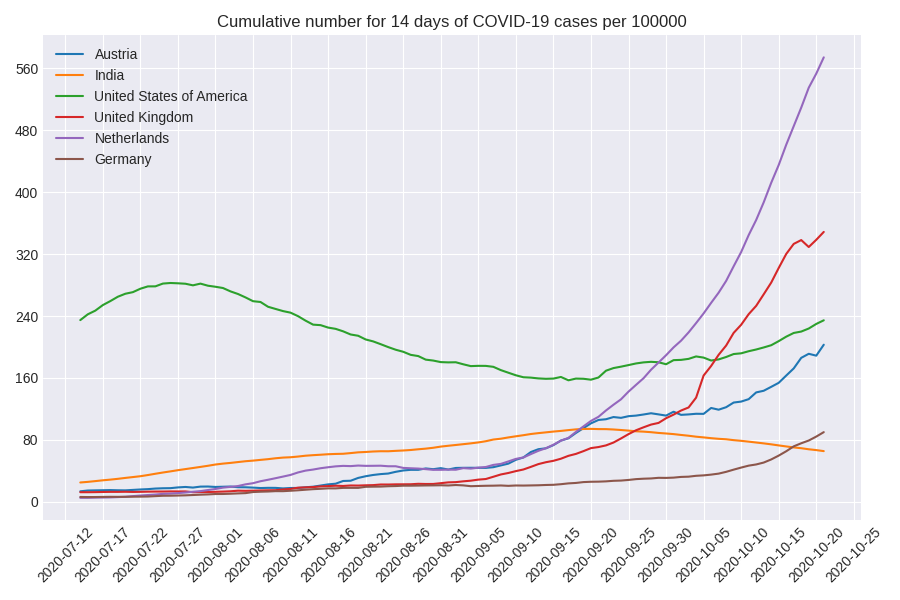

cases                                     \
                           rolling_avg                        last_5_days   
countriesAndTerritories                                                     
United_States_of_America  59512.857143  70256, 56611, 47843, 60160, 58549   
India                     58816.857143  62212, 61871, 55722, 46790, 54044   
United_Kingdom            18231.714286  15635, 16171, 16981, 18803, 21330   
Netherlands                7920.142857       7978, 8105, 8439, 7720, 8149   
Germany                    6596.714286       7830, 5587, 4325, 6868, 7595   
Austria                    1521.714286       1691, 2040, 1062, 1054, 1803   

                                 deaths                              \
                            max     sum last_7_days_sum rolling_avg   
countriesAndTerritories                                               
United_States_of_America  78427  221066            5164  737.714286   
India                     97894  115914            5328  761.142857   
United_Kingdom            22961   43967             949  135.571429   
Netherlands                8439    6804             182   26.000000   
Germany                    7830    9875             198   28.285714   
Austria                    2040     927              48    6.857143   

                                                          \
                                       last_5_days   max   
countriesAndTerritories                                    
United_States_of_America   899, 690, 385, 459, 933  4928   
India                     837, 1033, 579, 587, 717  2003   
United_Kingdom               136, 150, 67, 80, 241  1224   
Netherlands                      16, 29, 23, 8, 45   234   
Germany                         33, 10, 12, 47, 39   315   
Austria                              7, 6, 3, 9, 8    31   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
United_States_of_America                                         234.510566           
India                                                             65.424794           
United_Kingdom                                                   348.745794           
Netherlands                                                      574.378334           
Germany                                                           89.950262           
Austria                                                          202.951311           

                                      
                                 max  
countriesAndTerritories               
United_States_of_America  282.723242  
India                      94.173835  
United_Kingdom            348.745794  
Netherlands               574.378334  
Germany                    89.950262  
Austria                   202.951311

In [46]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ('AT', 'IN', 'US', 'UK', 'NL', 'DE', )
SELECTION =  df[df.geoId.isin(countries)]

ecdc.plot_comparison(countries, log=False, ndays=100)
ecdc.overview(SELECTION)

## Sweden and the world

<IPython.core.display.Javascript object>


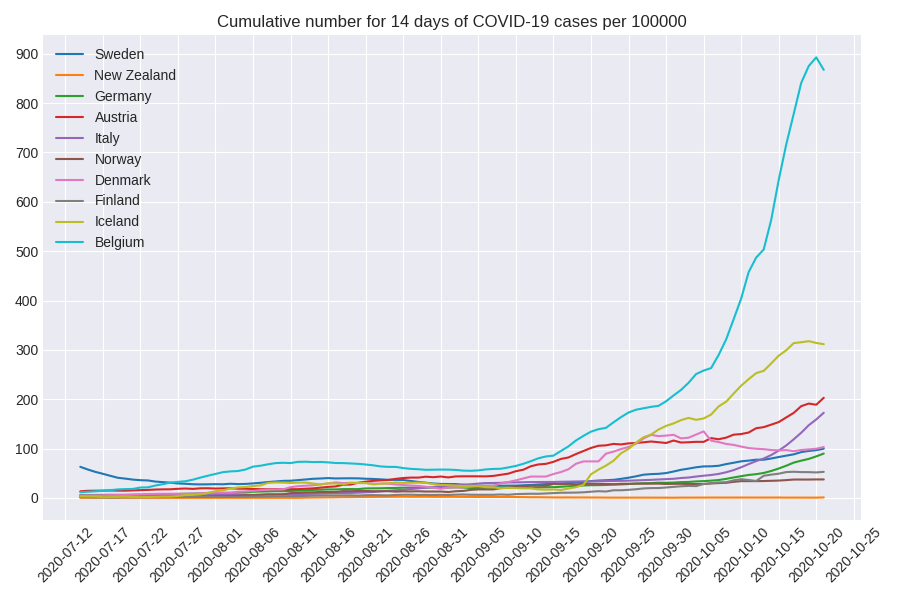

<AxesSubplot:title={'center':'Cumulative number for 14 days of COVID-19 cases per 100000'}>

In [39]:
countries = ('SE', 'NZ','DE','AT','IT','NO','DK','FI','IS','BE')
ecdc.plot_comparison(countries, log=False, ndays=100)


### World

In [40]:
ecdc.overview(df).head(5)

cases                                     \
                           rolling_avg                        last_5_days   
countriesAndTerritories                                                     
United_States_of_America  59512.857143  70256, 56611, 47843, 60160, 58549   
India                     58816.857143  62212, 61871, 55722, 46790, 54044   
France                    24896.142857  25086, 32427, 29837, 13243, 20468   
Brazil                    22903.714286  30914, 24062, 10982, 15383, 23227   
United_Kingdom            18231.714286  15635, 16171, 16981, 18803, 21330   

                                 deaths                              \
                            max     sum last_7_days_sum rolling_avg   
countriesAndTerritories                                               
United_States_of_America  78427  221066            5164  737.714286   
India                     97894  115914            5328  761.142857   
France                    32427   33885             952  136.000000   
Brazil                    69074  154837            3839  548.428571   
United_Kingdom            22961   43967             949  135.571429   

                                                          \
                                       last_5_days   max   
countriesAndTerritories                                    
United_States_of_America   899, 690, 385, 459, 933  4928   
India                     837, 1033, 579, 587, 717  2003   
France                       178, 89, 85, 146, 262  2004   
Brazil                     754, 461, 230, 271, 661  1595   
United_Kingdom               136, 150, 67, 80, 241  1224   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
United_States_of_America                                         234.510566           
India                                                             65.424794           
France                                                           441.679251           
Brazil                                                           144.427242           
United_Kingdom                                                   348.745794           

                                      
                                 max  
countriesAndTerritories               
United_States_of_America  282.723242  
India                      94.173835  
France                    441.679251  
Brazil                    304.320523  
United_Kingdom            348.745794

# Austria

## Plots

<IPython.core.display.Javascript object>


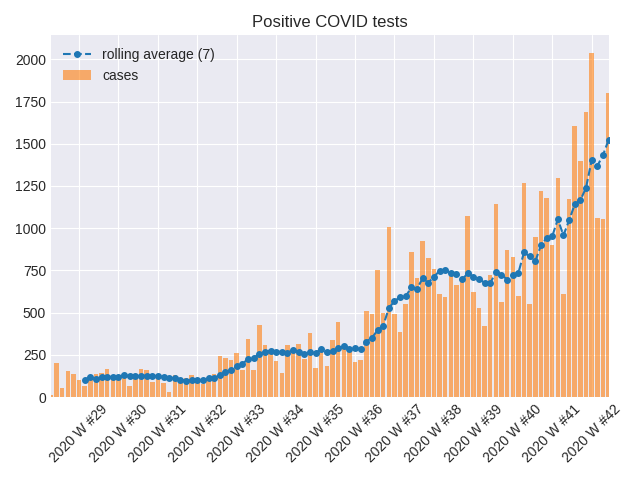

In [42]:
ecdc.plot_country('AT', log=LOG_PLOT, ndays=NDAYS, roll_days=7);

# India

<IPython.core.display.Javascript object>


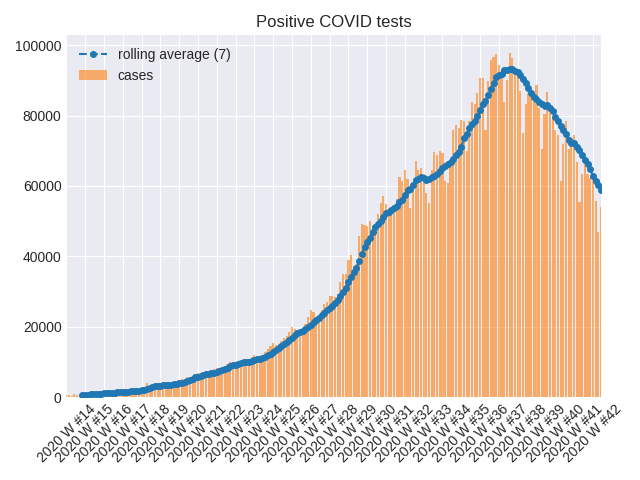

In [43]:
ecdc.plot_country('IN', log=LOG_PLOT,ndays=200, roll_days=7);

# USA

<IPython.core.display.Javascript object>


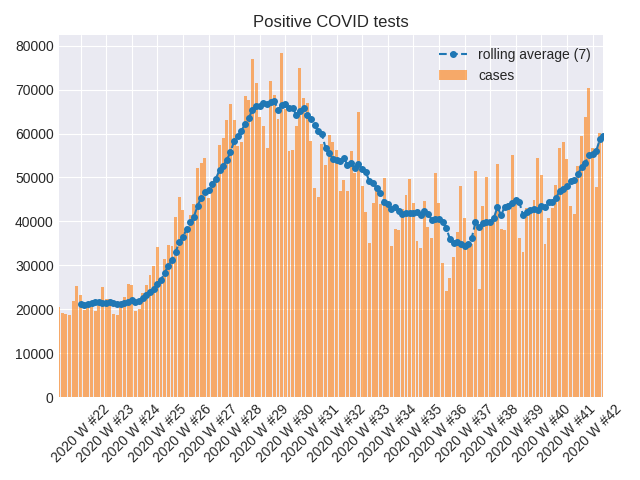

In [44]:
ecdc.plot_country('US', log=LOG_PLOT,ndays=150, roll_days=7);


# Germany

<IPython.core.display.Javascript object>


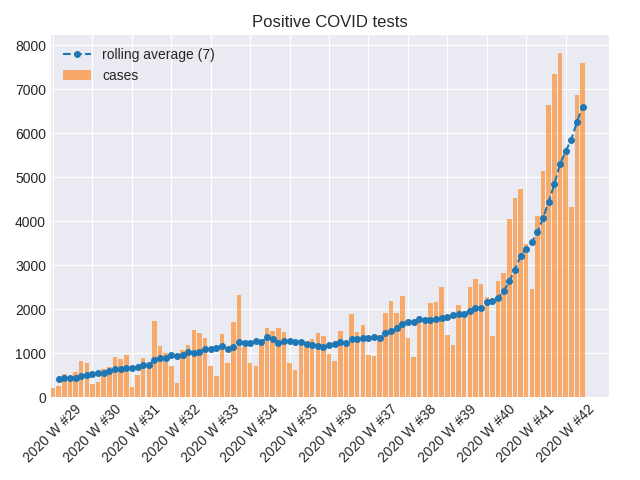

In [45]:
ecdc.plot_country('DE', log=LOG_PLOT,ndays=NDAYS, roll_days=7);

## UK

<IPython.core.display.Javascript object>


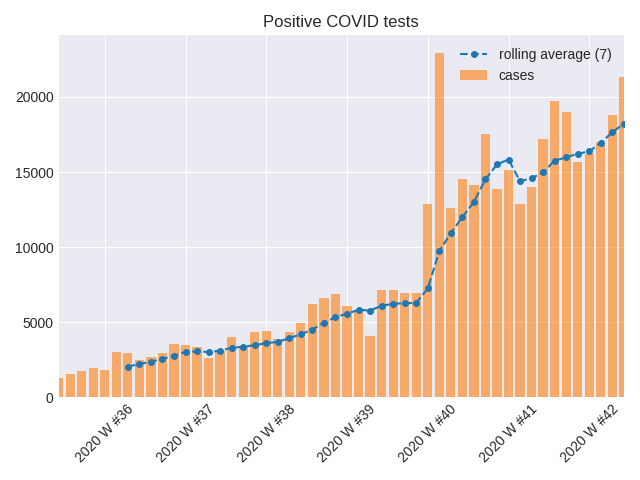

In [15]:
ecdc.plot_country('UK', log=LOG_PLOT,ndays=NDAYS,roll_days=7);

# Commit and Push

In [16]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular 2f73c29] Last run on 2020-10-21 12:19
 3 files changed, 1639 insertions(+), 589 deletions(-)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 16 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 938.59 KiB | 9.11 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:gythaogg/covid19.git
   59725a3..2f73c29  feature/angular -> feature/angular


In [41]:
! git push --set-upstream origin feature/angular


Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
Everything up-to-date
